In [86]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2
import os
from tqdm import tqdm
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from random import shuffle
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model



import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

In [87]:
model = load_model('mobilenetv2_model_v6.h5')

In [88]:
img1 = "ISIC_0000000.jpg"
img2 ="ISIC_0000002.jpg"
img3 = "ISIC_0024331.jpg"

In [89]:
img_path='ISIC_0000002.jpg'
img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

# Preprocessing the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

In [90]:
class_dict ={0:"Basal_Cell_Carcinoma (Cancer)",
             1:"Melanoma (Cancer)",
             2:"Nevus (Non-Cancerous)",
             3:"BKL (Cancer)",
             4:"NC (No Cancer)"}

In [91]:
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  preds = model.predict(img)[0]
  prediction = sorted(
      [(class_dict[i], round(j*100, 2)) for i, j in enumerate(preds)],
      reverse=True,
      key=lambda x: x[1]
  )

  return prediction

In [92]:
pred_image(img1,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[('Nevus (Non-Cancerous)', 99.81),
 ('Melanoma (Cancer)', 0.19),
 ('Basal_Cell_Carcinoma (Cancer)', 0.0),
 ('BKL (Cancer)', 0.0),
 ('NC (No Cancer)', 0.0)]

In [93]:
import tensorflow as tf
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
    model.inputs,  # Remove the extra square brackets
    [model.get_layer(last_conv_layer_name).output, model.output]
    )


    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [94]:
# Prepare image
img_size=(224,224)

img = Image.open(img1).resize((224,224)) #target_size must agree with what the trained model expects!!

# Preprocessing the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


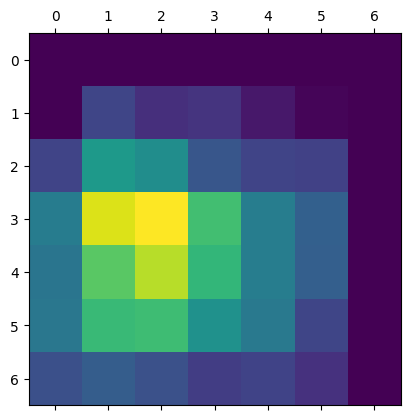

In [95]:
# Generate class activation heatmap
last_conv_layer_name = "block_16_depthwise"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [96]:
def generate_heatmap(img_path,last_conv_layer_name):
  # Prepare image
  img_size=(224,224)

  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

  # Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  # Remove last layer's softmax
  model.layers[-1].activation = None
  heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

  return heatmap


In [97]:
heatmap =generate_heatmap(img2,"block_16_depthwise")

In [98]:
from IPython.display import Image as imgdisp, display
def save_and_display_gradcam(img_path, heatmap, cam_path="/content/ISIC_0024457.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)


    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(imgdisp(cam_path))



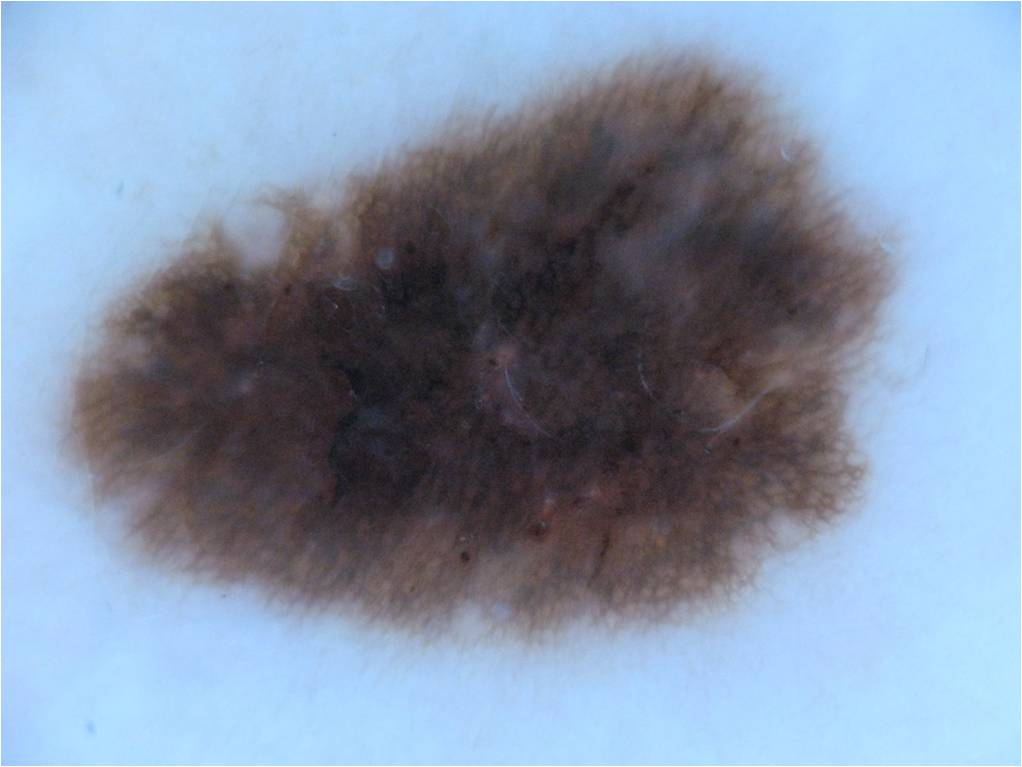

In [99]:
display(imgdisp(img1))

<ipython-input-98-774cc5ad0db0>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


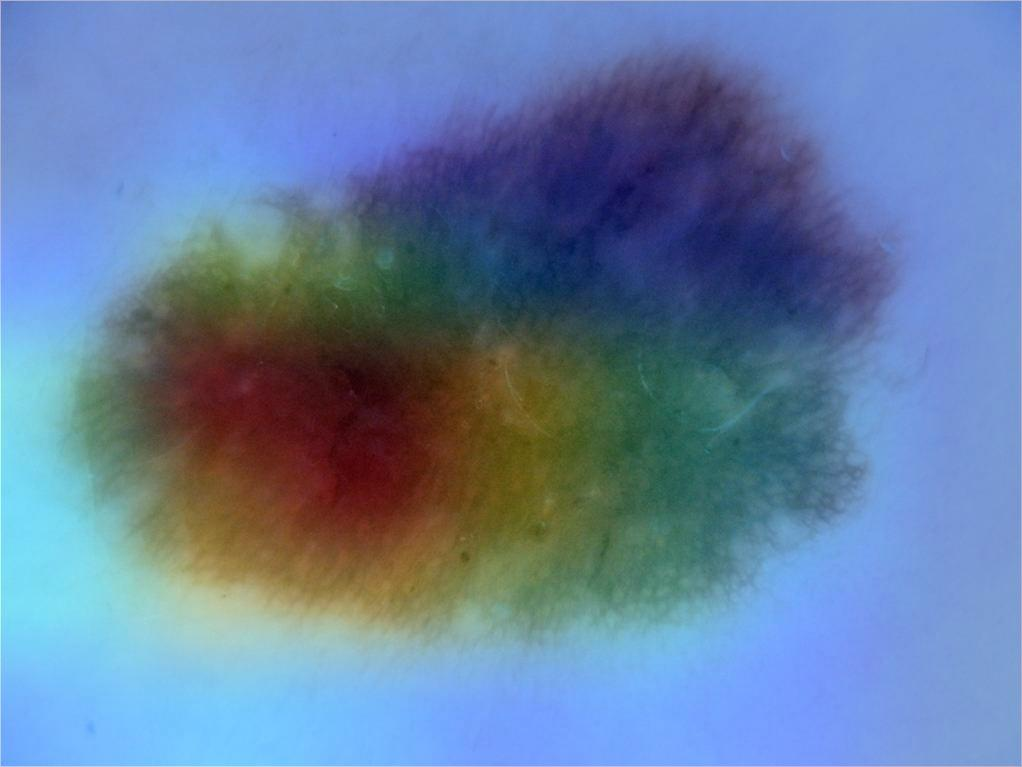

In [100]:
heatmap =generate_heatmap(img1,"block_16_depthwise")
save_and_display_gradcam(img1, heatmap)

<ipython-input-98-774cc5ad0db0>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


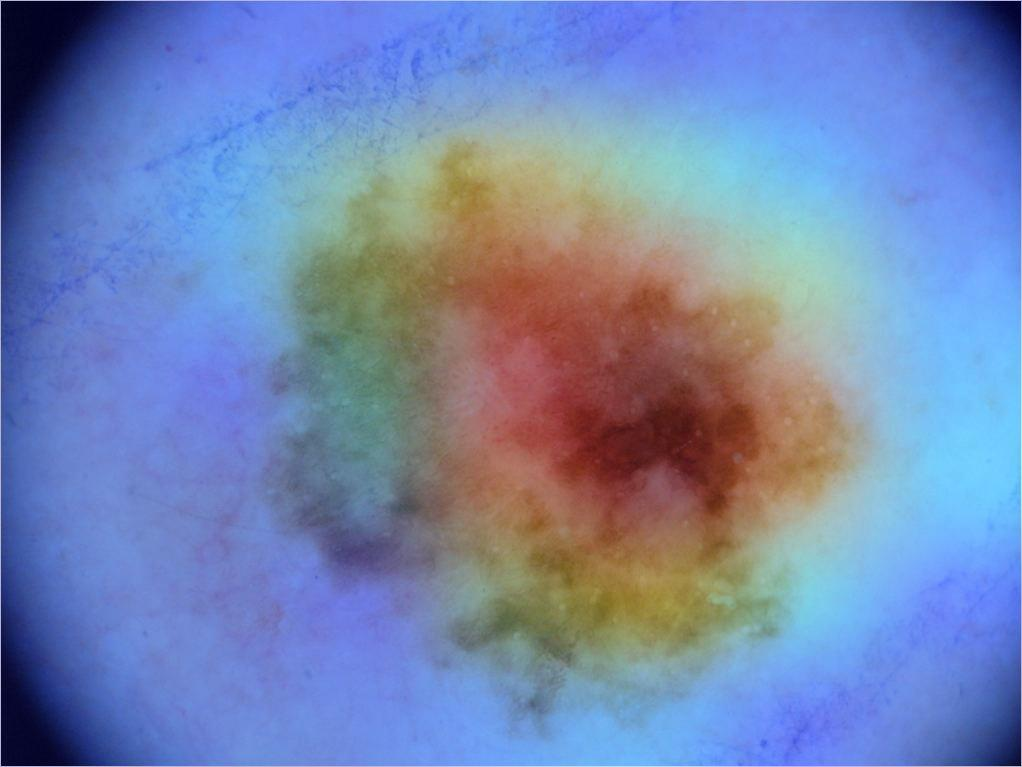

In [101]:
heatmap =generate_heatmap(img2,"block_16_depthwise")
save_and_display_gradcam(img2, heatmap)

In [102]:
model = load_model('mobilenetv2_model_v6.h5')

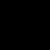

In [103]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import this for displaying images in Colab

# Load the image
image = cv2.imread('/content/ISIC_0000000.jpg', cv2.IMREAD_GRAYSCALE)

# Perform edge detection (Canny edge detector, for example)
edges = cv2.Canny(image, 100, 200)

# Get the center of the image
height, width = image.shape
center = (width // 2, height // 2)

# Define a region around the center (e.g., 50x50 pixels)
region_size = 50
top_left = (center[0] - region_size // 2, center[1] - region_size // 2)
bottom_right = (center[0] + region_size // 2, center[1] + region_size // 2)

# Extract the boundary in the region around the center
region = edges[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

# Display the result (boundary voxels at the center)
cv2_imshow(region)  # This works in Colab instead of cv2.imshow()


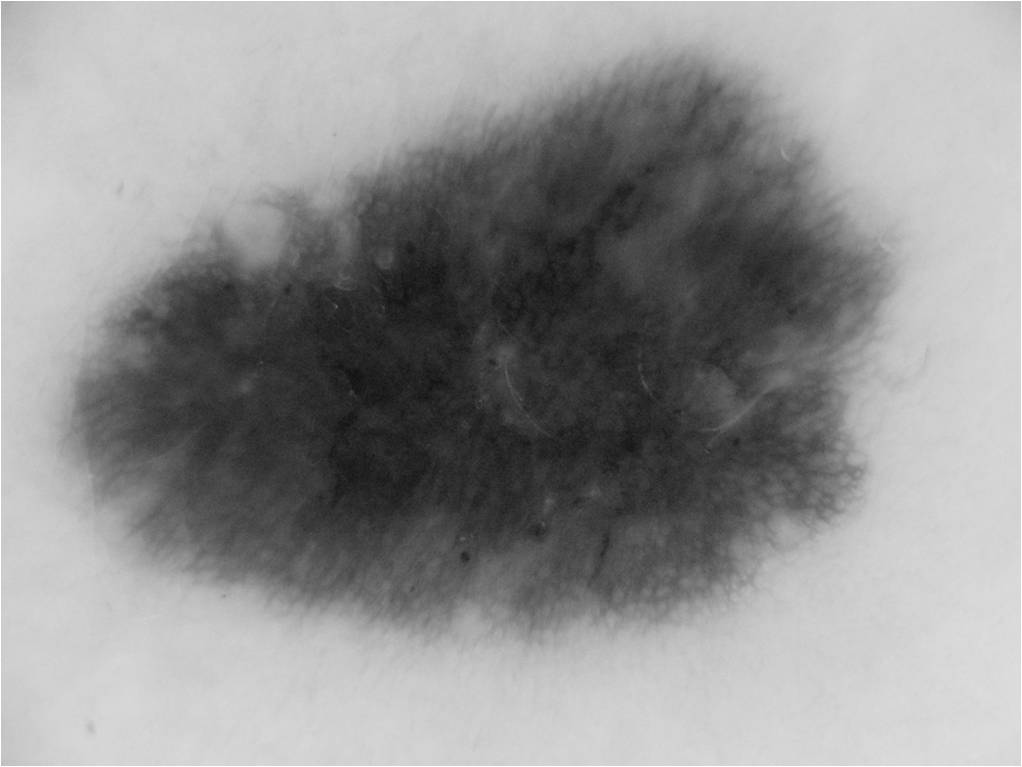

In [104]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import this for displaying images in Colab

# Load the image
image = cv2.imread('/content/ISIC_0000000.jpg', cv2.IMREAD_GRAYSCALE)

# Display the complete image
cv2_imshow(image)  # This will display the full image in Colab


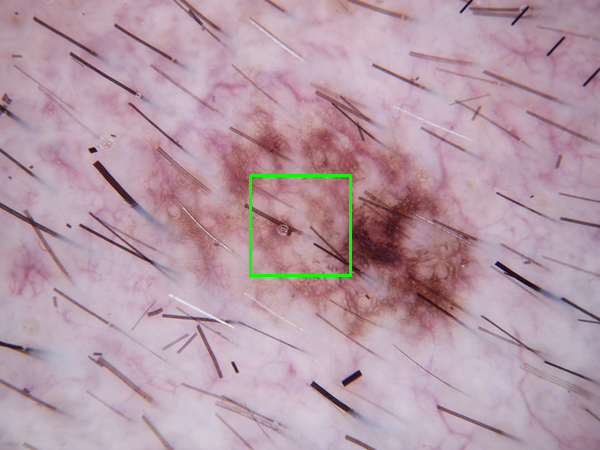

In [114]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import this for displaying images in Colab

# Load the image
image = cv2.imread('/content/ISIC_0024420.jpg')  # Use the full image without converting to grayscale

# Get the dimensions of the image
height, width, _ = image.shape

# Define the size of the box (e.g., 100x100 pixels)
box_width, box_height = 100, 100

# Calculate the top-left and bottom-right corners of the first box centered in the image
center_x, center_y = width // 2, height // 2
top_left = (center_x - box_width // 2, center_y - box_height // 2)
bottom_right = (center_x + box_width // 2, center_y + box_height // 2)

# Draw the first rectangle (green)
cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)  # Green color with thickness of 2
# Display the image with both boxes
cv2_imshow(image)